# Home Assignment 1

## Problem 1 (1 point). My Hashrate

This is a simple implemetation of Proof-of-Work function.
It takes current block header and block calculation difficulty as inputs and returns nonce for this block and the header of a mined block.

In [1]:
import hashlib

def proof_of_work(header, target):
    max_nonce = 2 ** 256 # увеличим макс нонс, чтобы уменьшить вероятность, что программа не найдет нужное число и зависнет 
    for nonce in range(max_nonce):
        hash_result = hashlib.sha256(str(header).encode('utf-8')+str(nonce).encode('utf-8')).hexdigest()

        if int(hash_result, 16) < target:
            return (hash_result, nonce)

The genesis block is calulated here.

In [2]:
import time

nonce = 0
block_hash = ""
new_block = 'This is the genesis block' + block_hash

difficulty_bits = 8
target = 2 ** (256-difficulty_bits)

start_time = time.time()
(block_hash, nonce) = proof_of_work(new_block, target)
end_time = time.time()
elapsed_time = end_time - start_time

print("Success with nonce ", nonce)
print("Hash is ", block_hash)
print("Elapsed time: %.4f seconds" % elapsed_time)

Success with nonce  186
Hash is  005eaab75f55d7cef91c03f04052043056113f6ee14abfcf4a0562a019aa1cbe
Elapsed time: 0.0002 seconds


### Task

Choose such a target that you will calculated 20 160 000 blocks per 14 days in avarage. Prove it experimetally (estimate time for at least 1000 blocks; compute both mean and standard deviation of a single block generation).

*Note.* Each next block should be calculated using the hash of the previous one.

In [3]:
# code here
target_blocks_count = 20160000
total_time_minutes = 14 * 24 * 60
total_time_seconds = total_time_minutes * 60
average_block_calc_time = total_time_seconds / target_blocks_count
print(total_time_minutes)
print(average_block_calc_time)

20160
0.06


In [4]:
%matplotlib inline
import numpy as np


'''Идея решения
Чтобы в среднем генерировалось 20160000 блоков за 14 дней, 1 блок должен генерироваться за 
0.06 секунд (average_block_calc_time).Таргет будем искать перебором. Перебираем difficulty(ограничу его 18,
чтобы построить график, после этого значения очень долго идут рассчеты; при необходимости его можно увеличить
до 256, если не хватает),на базе которого считается таргет и создаем цепочки из 100 блоков на каждом 
параметре и считаем mean и std mean(чем длиннее цепочка, тем более точные параметры средних значений и 
тем точнее эксперемент). 

'''

max_difficulty = 18
max_blocks_count = 100

time_array = np.zeros((max_blocks_count, max_difficulty))

for db in range(max_difficulty): # 1..<=max_difficulty # итерируемся по difficulty
    block_hash = ""
    new_block = 'This is the genesis block' + block_hash
    for index in range(max_blocks_count): # генерируем блоки и считаем время каждого
        local_target = 2 ** (256 - (db+1))
        
        start_time = time.time()
        (block_hash, nonce) = proof_of_work(new_block, local_target)
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        time_array[index, db] = elapsed_time
        new_block = str(block_hash) + str(nonce)

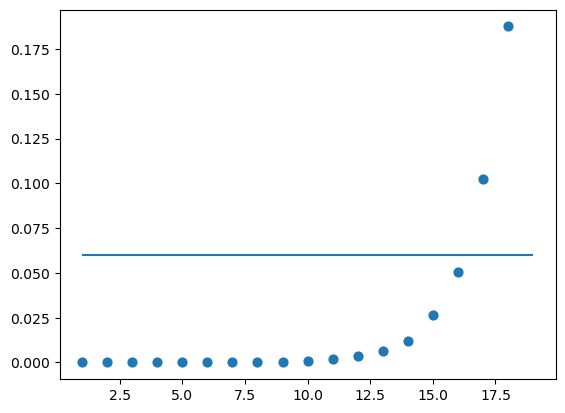

In [5]:
import matplotlib.pyplot as plt
#plt.loglog([2**x for x in range(1, max_difficulty+1)], np.mean(time_array,0))
plt.scatter(range(1, max_difficulty+1), np.mean(time_array,0), s=40, marker='o')
plt.hlines(average_block_calc_time, 1, max_difficulty+1)

In [6]:
def build_blockchain(blocks_count, target):
    block_hash = ""
    new_block = 'This is the genesis block' + block_hash
    for index in range(blocks_count): # генерируем блоки и считаем время каждого
        (block_hash, nonce) = proof_of_work(new_block, target)
        new_block = str(block_hash) + str(nonce)

In [7]:
mean_array = np.mean(time_array, 0).tolist()
std_array = np.std(time_array, 0).tolist()
for i in range(1, len(mean_array)):
    if average_block_calc_time >= mean_array[i-1] and average_block_calc_time <= mean_array[i]:
        if (abs(mean_array[i] - average_block_calc_time)) < (abs(mean_array[i-1] - average_block_calc_time)):      
            index = i
        else:
            index = i-1
        final_difficult = index + 1
        print(f"final difficult = {final_difficult}, target = 2^{256-final_difficult}, mean = {mean_array[index]}, mean std = {std_array[index]}")
        
        # проверка, должно быть около минуты, погрешность также дает не точный mean из-за количества данных
        start_time = time.time()
        build_blockchain(1000, 2**(256-final_difficult))
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(elapsed_time)

final difficult = 16, target = 2^240, mean = 0.05029253244400025, mean std = 0.050056526170538
46.67307209968567


## Problem 2 (3 + 3* points). Merkle tree

Merkle hash trees play an important role in forming transaction blocks in blockchain. In this assignment we ask you to plot your own Merkle hash tree and check its' properties. Below we provide you with some code fragment what you can use in your assignment

In [8]:
import matplotlib
import networkx as nx
#%matplotlib qt5
from networkx import balanced_tree, draw_networkx, draw

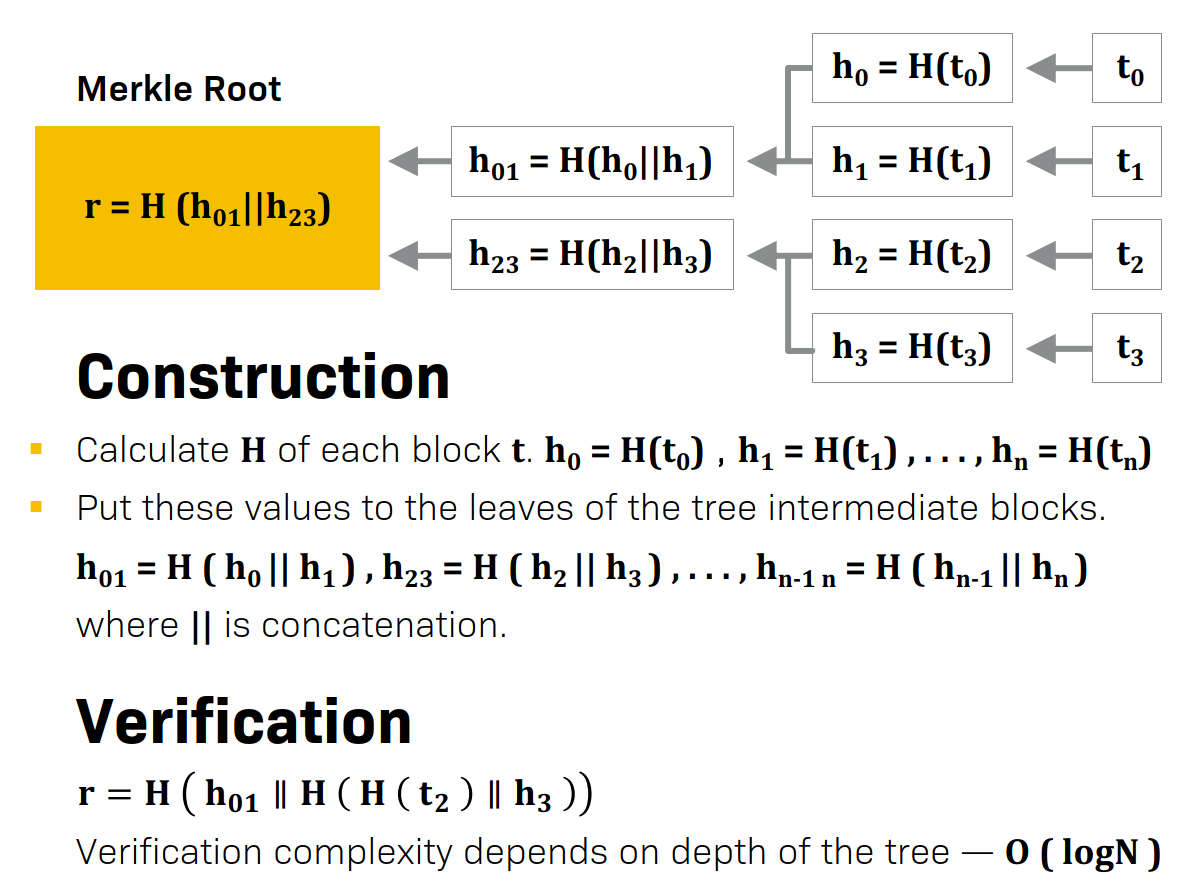

Let us plot graph basis for Merkle hash tree

{0: Text(0, 4, '0'),
 1: Text(-2, 3, '1'),
 2: Text(2, 3, '2'),
 3: Text(-3, 2, '3'),
 4: Text(-1, 2, '4'),
 5: Text(1, 2, '5'),
 6: Text(3, 2, '6'),
 7: Text(-3, 1, 'tx1'),
 8: Text(-1, 1, 'tx2'),
 9: Text(1, 1, 'tx3'),
 10: Text(3, 1, 'tx4')}

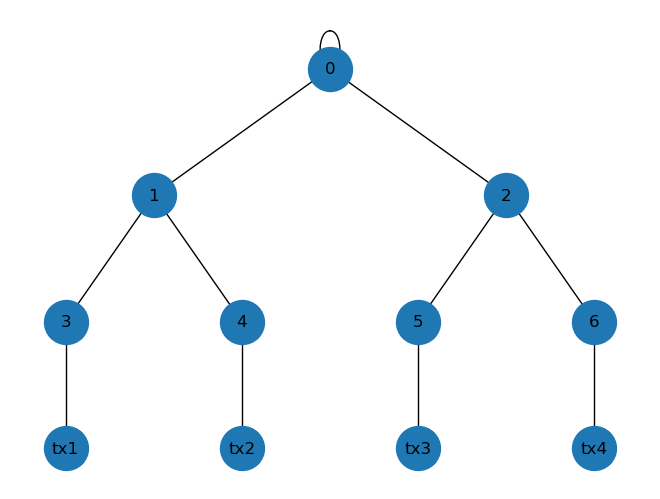

In [9]:
G = nx.Graph()
positions = {}
coordinates = [
    [0, 4],
    [-2, 3],
    [2, 3],
    [-3, 2],
    [-1, 2],
    [1, 2],
    [3, 2],
    [-3, 1],
    [-1, 1],
    [1, 1],
    [3, 1]
]
parents = [0, 0, 0, 1, 1, 2, 2, 3, 4, 5, 6]
for index in range(11):
    G.add_node(index)
    G.add_edge(index, parents[index])
    positions[index] = coordinates[index]
nx.draw(G, positions, node_size = 1000)
labels = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: 'tx1',
    8: 'tx2',
    9: 'tx3',
    10: 'tx4',
}
nx.draw_networkx_labels(G, positions, labels = labels)

In Bitcoin double sha256 hash scheme is used. Here is an example.

In [10]:
import hashlib


first_hash = hashlib.sha256(b"hello") # "b" stands for binary representation
second_hash = hashlib.sha256()
print('First hash represented as a hexadecimal number:', first_hash.hexdigest())
second_hash.update(first_hash.digest())
print('Second hash represented as a hexadecimal number:', second_hash.hexdigest())

First hash represented as a hexadecimal number: 2cf24dba5fb0a30e26e83b2ac5b9e29e1b161e5c1fa7425e73043362938b9824
Second hash represented as a hexadecimal number: 9595c9df90075148eb06860365df33584b75bff782a510c6cd4883a419833d50


Now we can easily change vertices' labels to hashes of corresponding messages and plot new graph

{0: Text(0, 4, '0'),
 1: Text(-2, 3, '1'),
 2: Text(2, 3, '2'),
 3: Text(-3, 2, '856a4921cd32690244af7568e7bd1391a94119e17c7f33234f4bf11271b223e5'),
 4: Text(-1, 2, '4'),
 5: Text(1, 2, '5'),
 6: Text(3, 2, '6'),
 7: Text(-3, 1, 'tx1'),
 8: Text(-1, 1, 'tx2'),
 9: Text(1, 1, 'tx3'),
 10: Text(3, 1, 'tx4')}

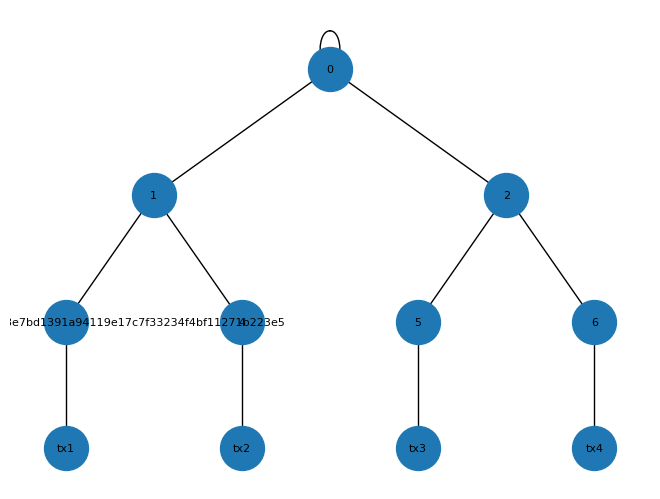

In [11]:
labels[3] = hashlib.sha256(hashlib.sha256(b"tx1").digest()).hexdigest()

# and plot the graph again

nx.draw(G, positions, node_size = 1000)
nx.draw_networkx_labels(G, positions, labels = labels, font_size = 8)

1) Construct Merkle hash tree using previously constructed graph by finding corresponding SHA256 hashes on vertices and plot obtained Merkle hash tree (1 point)

In [12]:
def get_double_hash(data):
    return hashlib.sha256(hashlib.sha256(data.encode('utf-8')).digest()).hexdigest()

In [13]:
class MerkleTreeFourLeafs: # класс дерева с четеримя листьями
    
    def __init__(self, leafs):
        self.labels = {
            0: '0',
            1: '1',
            2: '2',
            3: '3',
            4: '4',
            5: '5',
            6: '6',
            7: 'tx1',
            8: 'tx2',
            9: 'tx3',
            10: 'tx4',
        }
        self.G = nx.Graph()
        self.parents = [0, 0, 0, 1, 1, 2, 2, 3, 4, 5, 6]
        self.positions = {}
        self.coordinates = [
            [0, 4],
            [-2, 3],
            [2, 3],
            [-3, 2],
            [-1, 2],
            [1, 2],
            [3, 2],
            [-3, 1],
            [-1, 1],
            [1, 1],
            [3, 1]
            ]
        
        for index in range(11):
            self.G.add_node(index)
            self.G.add_edge(index, self.parents[index])
            self.positions[index] = self.coordinates[index]
            
        self.update_tree(leafs)
        

    def update_tree(self, leafs):
        if len(leafs) != 4:
            raise Error("Incorrect count of leafs")
            return 
        
        # Обновим листья
        for i in range(0, 4):
            self.labels[i + 7] = leafs[i]
        
        for i in range(3, 7):
            self.labels[i] = get_double_hash(self.labels[i + 4])
        
        for i in range(2, -1, -1):
            self.labels[i] = get_double_hash(self.labels[2*i+1] + self.labels[2*i+2])
        
    def draw_tree(self):
        nx.draw(self.G, self.positions, node_size = 1000)
        nx.draw_networkx_labels(self.G, self.positions, labels = self.labels, font_size = 8)
        
    def proof_of_correctness_tx1(self, tx1):
        new_root = get_double_hash(get_double_hash(get_double_hash(tx1) +
                                                   self.labels[4])+self.labels[2])
        if new_root == self.labels[0]:
            return f"Tx 1 is correct. Base root - {self.labels[0]}, new root - {new_root}"
        else:
            return f"Tx 1 is incorrect. Base root - {self.labels[0]}, new root - {new_root}"
        
    def proof_of_correctness_tx1_tx2(self, tx1, tx2):
        new_root = get_double_hash(get_double_hash(get_double_hash(tx1) + get_double_hash(tx2)) +self.labels[2])
        
        if new_root == self.labels[0]:
            return f"Set tx1 + tx2 is correct. Base root - {self.labels[0]}, new root - {new_root}"
        else:
            return f"Set tx1 + tx2 is incorrect. Base root - {self.labels[0]}, new root - {new_root}"
        

{0: '5eaee129fb6c4761a542e919f8fd0fa3f3c3d83a33bbeeec5a7e8772ddfb8f88', 1: '41925fc3630f375e23755f04099f1b2c51f372a9792762b28478fbbc5faf1106', 2: '5c72c2fc6c2ed732c66fa8dc63f163617be1eb6175b88b3b640f440abb236e73', 3: '856a4921cd32690244af7568e7bd1391a94119e17c7f33234f4bf11271b223e5', 4: '79043a4d1d4d6d0b830519bfc07b92b4d162a4cd54235719c2c3cc211a638dfd', 5: 'ef729c31d206229249bd791b29676d26cc7465aa6bc2003d80c7a82a316e0233', 6: '4746dc9c16f97469fa45710394c4a0e2f29226efc04cab47c29ce579ae19a74e', 7: 'tx1', 8: 'tx2', 9: 'tx3', 10: 'tx4'}


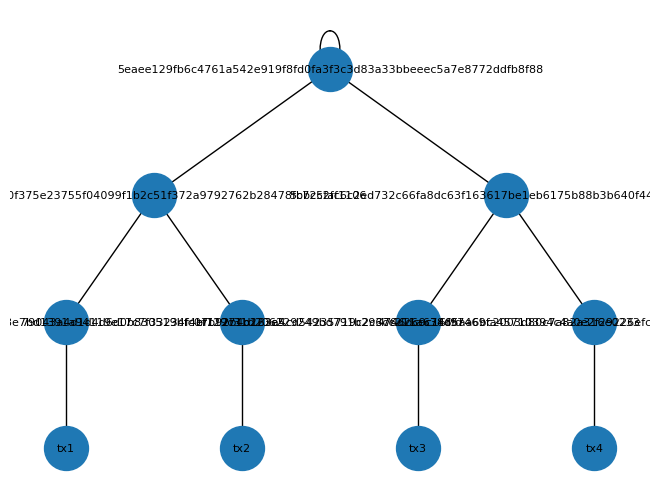

In [14]:
four_leafs_tree = MerkleTreeFourLeafs(["tx1", "tx2", "tx3", "tx4"])
print(four_leafs_tree.labels)
four_leafs_tree.draw_tree()

2) Provide a proof of correctness of leaf tx1 and set of leafs tx1-tx2 (1 point)

In [15]:
# code
print(four_leafs_tree.proof_of_correctness_tx1("tx1"))

Tx 1 is correct. Base root - 5eaee129fb6c4761a542e919f8fd0fa3f3c3d83a33bbeeec5a7e8772ddfb8f88, new root - 5eaee129fb6c4761a542e919f8fd0fa3f3c3d83a33bbeeec5a7e8772ddfb8f88


In [16]:
print(four_leafs_tree.proof_of_correctness_tx1_tx2("tx1", "tx2"))

Set tx1 + tx2 is correct. Base root - 5eaee129fb6c4761a542e919f8fd0fa3f3c3d83a33bbeeec5a7e8772ddfb8f88, new root - 5eaee129fb6c4761a542e919f8fd0fa3f3c3d83a33bbeeec5a7e8772ddfb8f88


3) Change the value on leaf tx1 and recompute corresponding hashes. Plot newly obtained Merkle hash tree (1 point)

{0: '7eca079f02d119666945118c8ab2fe2c1b2fb8bbd1b8ce0b9d507df38e411a54', 1: '50634cdc8254528bc4749f5e12e7caa91958dbe4ce989a4c7e7092997ec30959', 2: '5c72c2fc6c2ed732c66fa8dc63f163617be1eb6175b88b3b640f440abb236e73', 3: 'd6af5a3f1c4f319ef25f765d5142834a77dbdafcdbc498853950b41aed3a8580', 4: '79043a4d1d4d6d0b830519bfc07b92b4d162a4cd54235719c2c3cc211a638dfd', 5: 'ef729c31d206229249bd791b29676d26cc7465aa6bc2003d80c7a82a316e0233', 6: '4746dc9c16f97469fa45710394c4a0e2f29226efc04cab47c29ce579ae19a74e', 7: 'AnotherTx', 8: 'tx2', 9: 'tx3', 10: 'tx4'}


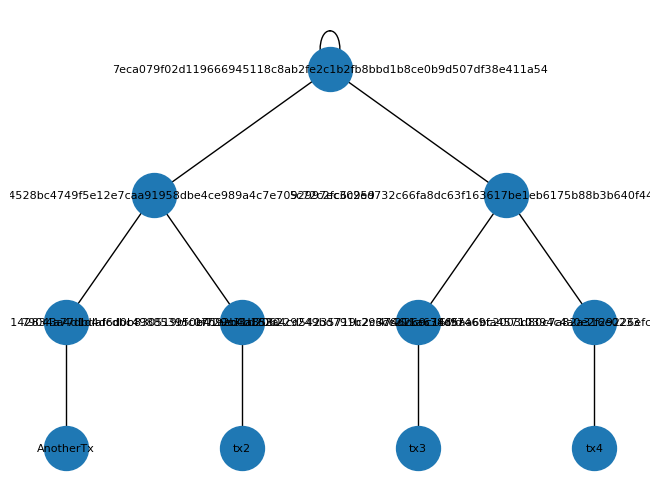

In [17]:
# code
edited_four_leafs_tree = MerkleTreeFourLeafs(["AnotherTx", "tx2", "tx3", "tx4"])
print(edited_four_leafs_tree.labels)
edited_four_leafs_tree.draw_tree()

4*) Implement a function to support the number of leafs $n =5, .., 16$. Let the value in the leaf $i$ be $txi$. Plot the tree. Provide the proof of correctness of leaf tx4 and set of leafs tx4-tx5 (3 bonus points)

In [18]:
class MerkleTreeEightLeafs: # класс дерева с 8 листьями
    
    def __init__(self, leafs):
        if len(leafs) != 8:
            raise Error("Incorrect leafs count")
        
        self.nodes_count = 15
        self.leafs_count = 8
        self.tree_size = 23
            
        self.labels = {
        }
        for i in range(self.nodes_count):
            self.labels[i] = str(i)
            
        for i in range(0, self.leafs_count):
            self.labels[self.nodes_count + i] = leafs[i]
        
        self.G = nx.Graph()
        self.parents = [0, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 8 , 9, 10, 11, 12, 13, 14]
        self.positions = {}
        self.coordinates = [
                [0, 0],
                [-5, -3],
                [5, -3],
                [-7, -5],
                [-3, -5],
                [3, -5],
                [7, -5],
                [-8, -7],
                [-6, -7],
                [-4, -7],
                [-2, -7],
                [2, -7],
                [4, -7],
                [6, -7],
                [8, -7],
                [-8, -9],
                [-6, -9],
                [-4, -9],
                [-2, -9],
                [2, -9],
                [4, -9],
                [6, -9],
                [8, -9]
            ]
        
        for index in range(len(self.coordinates)):
            self.G.add_node(index)
            self.G.add_edge(index, self.parents[index])
            self.positions[index] = self.coordinates[index]
            
        self.update_tree(leafs)
        

    def update_tree(self, leafs):
        if len(leafs) != 8:
            raise Error("Incorrect count of leafs")
            return 
        
        # Обновим листья
        for i in range(0, 8):
            self.labels[i + self.nodes_count] = leafs[i]
        
        for i in range(self.nodes_count - self.leafs_count, self.nodes_count):
            self.labels[i] = get_double_hash(self.labels[i + self.leafs_count])
        
        for i in range(self.nodes_count - self.leafs_count - 1, -1, -1):
            self.labels[i] = get_double_hash(self.labels[2*i+1] + self.labels[2*i+2])
        
    def draw_tree(self):
        nx.draw(self.G, self.positions, node_size = 1000)
        nx.draw_networkx_labels(self.G, self.positions, labels = self.labels, font_size = 8)
        
    def proof_of_correctness_tx4(self, tx4):
        # считаю отдельно ноды, чтобы не очень большое выражение было
        temp_hash_4 = get_double_hash(self.labels[9]+get_double_hash(tx4))
        temp_hash_1 = get_double_hash(self.labels[3]+ temp_hash_4 )
        new_root = get_double_hash(temp_hash_1 + self.labels[2])
        
        if new_root == self.labels[0]:
            return f"Tx 4 is correct. Base root - {self.labels[0]}, new root - {new_root}"
        else:
            return f"Tx 4 is incorrect. Base root - {self.labels[0]}, new root - {new_root}"
        
    def proof_of_correctness_tx4_tx5(self, tx4, tx5):        
        temp_hash_4 = get_double_hash(self.labels[9]+get_double_hash(tx4))
        temp_hash_1 = get_double_hash(self.labels[3]+ temp_hash_4 )
        
        temp_hash_5 = get_double_hash(get_double_hash(tx5) + self.labels[12])
        temp_hash_2 = get_double_hash(temp_hash_5+self.labels[6])
        
        new_root = get_double_hash(temp_hash_1 + temp_hash_2)
        if new_root == self.labels[0]:
            return f"Set tx4 + tx5 is correct. Base root - {self.labels[0]}, new root - {new_root}"
        else:
            return f"Set tx4 + tx5 is incorrect. Base root - {self.labels[0]}, new root - {new_root}"

In [19]:
class MerkleTree16Leafs: # класс дерева с 16 листьями
    
    def __init__(self, leafs):
        if len(leafs) != 16:
            raise Error("Incorrect leafs count")
        
        self.nodes_count = 31
        self.leafs_count = 16
        self.tree_size = 47
            
        self.labels = {
        }
        for i in range(self.nodes_count):
            self.labels[i] = str(i)
            
        for i in range(0, self.leafs_count):
            self.labels[self.nodes_count + i] = leafs[i]
        
        self.G = nx.Graph()
        self.parents = [0, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14,
                      15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
        self.positions = {}
        self.coordinates = [
                [0, 0],
                [-9, -2],
                [9, -2],
                [-13, -4],
                [-5, -4],
                [5, -4],
                [13, -4],
                [-15, -6],
                [-11, -6],
                [-7, -6],
                [-3, -6],
                [3, -6],
                [7, -6],
                [11, -6],
                [15, -6],
                [-16, -8],
                [-14, -8],
                [-12, -8],
                [-10, -8],
                [-8, -8],
                [-6, -8],
                [-4, -8],
                [-2, -8],
                [2, -8],
                [4, -8],
                [6, -8],
                [8, -8],
                [10, -8],
                [12, -8],
                [14, -8],
                [16, -8],
                [-16, -10],
                [-14, -10],
                [-12, -10],
                [-10, -10],
                [-8, -10],
                [-6, -10],
                [-4, -10],
                [-2, -10],
                [2, -10],
                [4, -10],
                [6, -10],
                [8, -10],
                [10, -10],
                [12, -10],
                [14, -10],
                [16, -10],
            ]
        
        for index in range(len(self.coordinates)):
            self.G.add_node(index)
            self.G.add_edge(index, self.parents[index])
            self.positions[index] = self.coordinates[index]
            
        self.update_tree(leafs)
        

    def update_tree(self, leafs):
        if len(leafs) != 16:
            raise Error("Incorrect count of leafs")
            return 
        
        # Обновим листья
        for i in range(0, self.leafs_count):
            self.labels[i + self.nodes_count] = leafs[i]
        
        for i in range(self.nodes_count - self.leafs_count, self.nodes_count):
            self.labels[i] = get_double_hash(self.labels[i + self.leafs_count])
        
        for i in range(self.nodes_count - self.leafs_count - 1, -1, -1):
            self.labels[i] = get_double_hash(self.labels[2*i+1] + self.labels[2*i+2])
        
    def draw_tree(self):
        nx.draw(self.G, self.positions, node_size = 1000)
        nx.draw_networkx_labels(self.G, self.positions, labels = self.labels, font_size = 8)
        
    def proof_of_correctness_tx4(self, tx4):
        # считаю отдельно ноды, чтобы не очень большое выражение было
        temp_hash_8 = get_double_hash(self.labels[17]+get_double_hash(tx4))
        temp_hash_3 = get_double_hash(self.labels[7]+ temp_hash_8 )
        temp_hash_1 = get_double_hash(temp_hash_3+self.labels[4] )
        new_root = get_double_hash(temp_hash_1 + self.labels[2])
        
        if new_root == self.labels[0]:
            return f"Tx 4 is correct. Base root - {self.labels[0]}, new root - {new_root}"
        else:
            return f"Tx 4 is incorrect. Base root - {self.labels[0]}, new root - {new_root}"
        
    def proof_of_correctness_tx4_tx5(self, tx4, tx5):        
        temp_hash_8 = get_double_hash(self.labels[17]+get_double_hash(tx4))
        temp_hash_3 = get_double_hash(self.labels[7]+ temp_hash_8 )
        
        temp_hash_9 = get_double_hash(get_double_hash(tx5) + self.labels[20])
        temp_hash_4 = get_double_hash(temp_hash_9 + self.labels[10])
        
        temp_hash_1 = get_double_hash(temp_hash_3 + temp_hash_4)
        
        
        new_root = get_double_hash(temp_hash_1 + self.labels[2])
        if new_root == self.labels[0]:
            return f"Set tx4 + tx5 is correct. Base root - {self.labels[0]}, new root - {new_root}"
        else:
            return f"Set tx4 + tx5 is incorrect. Base root - {self.labels[0]}, new root - {new_root}"

{0: 'ba0a9eecb0392d6e01febbb7b8940775320c9798732af2158b64d744fedcd2e5', 1: '7ed0ef1f4a0f7e02413d0f19708f9bde561158a5edd44315ea84e0f18ad7bce3', 2: '3f1b0b66978bb42cc238ced517ad7e05d17b8a4dd55068a836cc7331a0e345d4', 3: '5eaee129fb6c4761a542e919f8fd0fa3f3c3d83a33bbeeec5a7e8772ddfb8f88', 4: 'd39c3a46d7a6dfcf4442264d564bd484d32bc7d4cf4557d66cf23564c20d90e9', 5: 'd3b59afdc93322a050a95b5dfc27451573923ca5484a6da7c976981098d0fb3d', 6: '5351555413dee5f72408b96c5917347b4b8c3b0b64eb60bee5de6598d48663e2', 7: '41925fc3630f375e23755f04099f1b2c51f372a9792762b28478fbbc5faf1106', 8: '5c72c2fc6c2ed732c66fa8dc63f163617be1eb6175b88b3b640f440abb236e73', 9: 'd6729da948be8eb1fddfc506ce39885194787a93bef6b3ab9086e1685bddfc2f', 10: 'ea7690966598257569c816a598a57638cfd7b0b1e43b1bf5d0a62f4de981a7e8', 11: '6bb20dd0d630085f7cce8f0c3b4517bd4c9ded476a77759fb0a93f74c017bdb5', 12: 'b7aa6f0c7ebb7fd834860360b1bb23181e8a05336dee67812a40d175dc34da8e', 13: '32670228702ac606420965809dc9adb9aa1b6ea85f794ca74b77a68a47615c13', 1

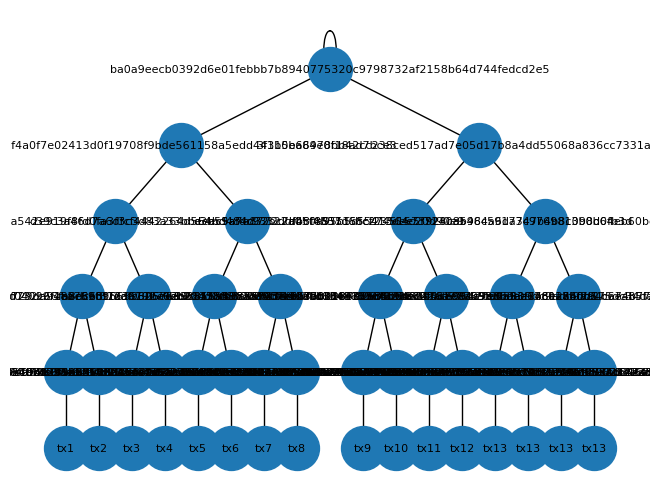

In [20]:
# code
def make_tree(n):
    if n < 5 or n > 16:
        raise Error("incorrect n ")
    if n < 9:
        leafs = [f"tx{i+1}" for i in range(n)] + [f"tx{n}" for i in range(8-n)]
        
        eight_leafs_tree = MerkleTreeEightLeafs(leafs)
        print(eight_leafs_tree.labels)
        eight_leafs_tree.draw_tree()
        print("\n")
        print(eight_leafs_tree.proof_of_correctness_tx4("tx4"))
        print(eight_leafs_tree.proof_of_correctness_tx4_tx5("tx4","tx5"))
    else:
        leafs = [f"tx{i+1}" for i in range(n)] + [f"tx{n}" for i in range(16-n)]
        leafs_16_tree = MerkleTree16Leafs(leafs)
        print(leafs_16_tree.labels)
        leafs_16_tree.draw_tree()
        print("\n")
        print(leafs_16_tree.proof_of_correctness_tx4("tx4"))
        print(leafs_16_tree.proof_of_correctness_tx4_tx5("tx4","tx5"))
make_tree(13)
        

## Problem 3 (6 + 2* points). Fork rate and main chain

Two miners are the only maintainers of the network. Each miner needs a random time to generate a new block which is modeled as exponential random variables with the rates $1/t_1$ and $1/t_2$ correspondingly. I.e. each miner generates Poisson point process of new blocks. The network is not ideal and it takes a random time to synchronize the block. The synchronization is modeled as an exponential random variable with the rate $1/t_0$. We assume both miners be honest and continue the longest known chain.

*Note.* The Poisson point process has memoryless and superposition properties [1]. So we can model three Poisson point processes independently and omit synchronization events if already synced.

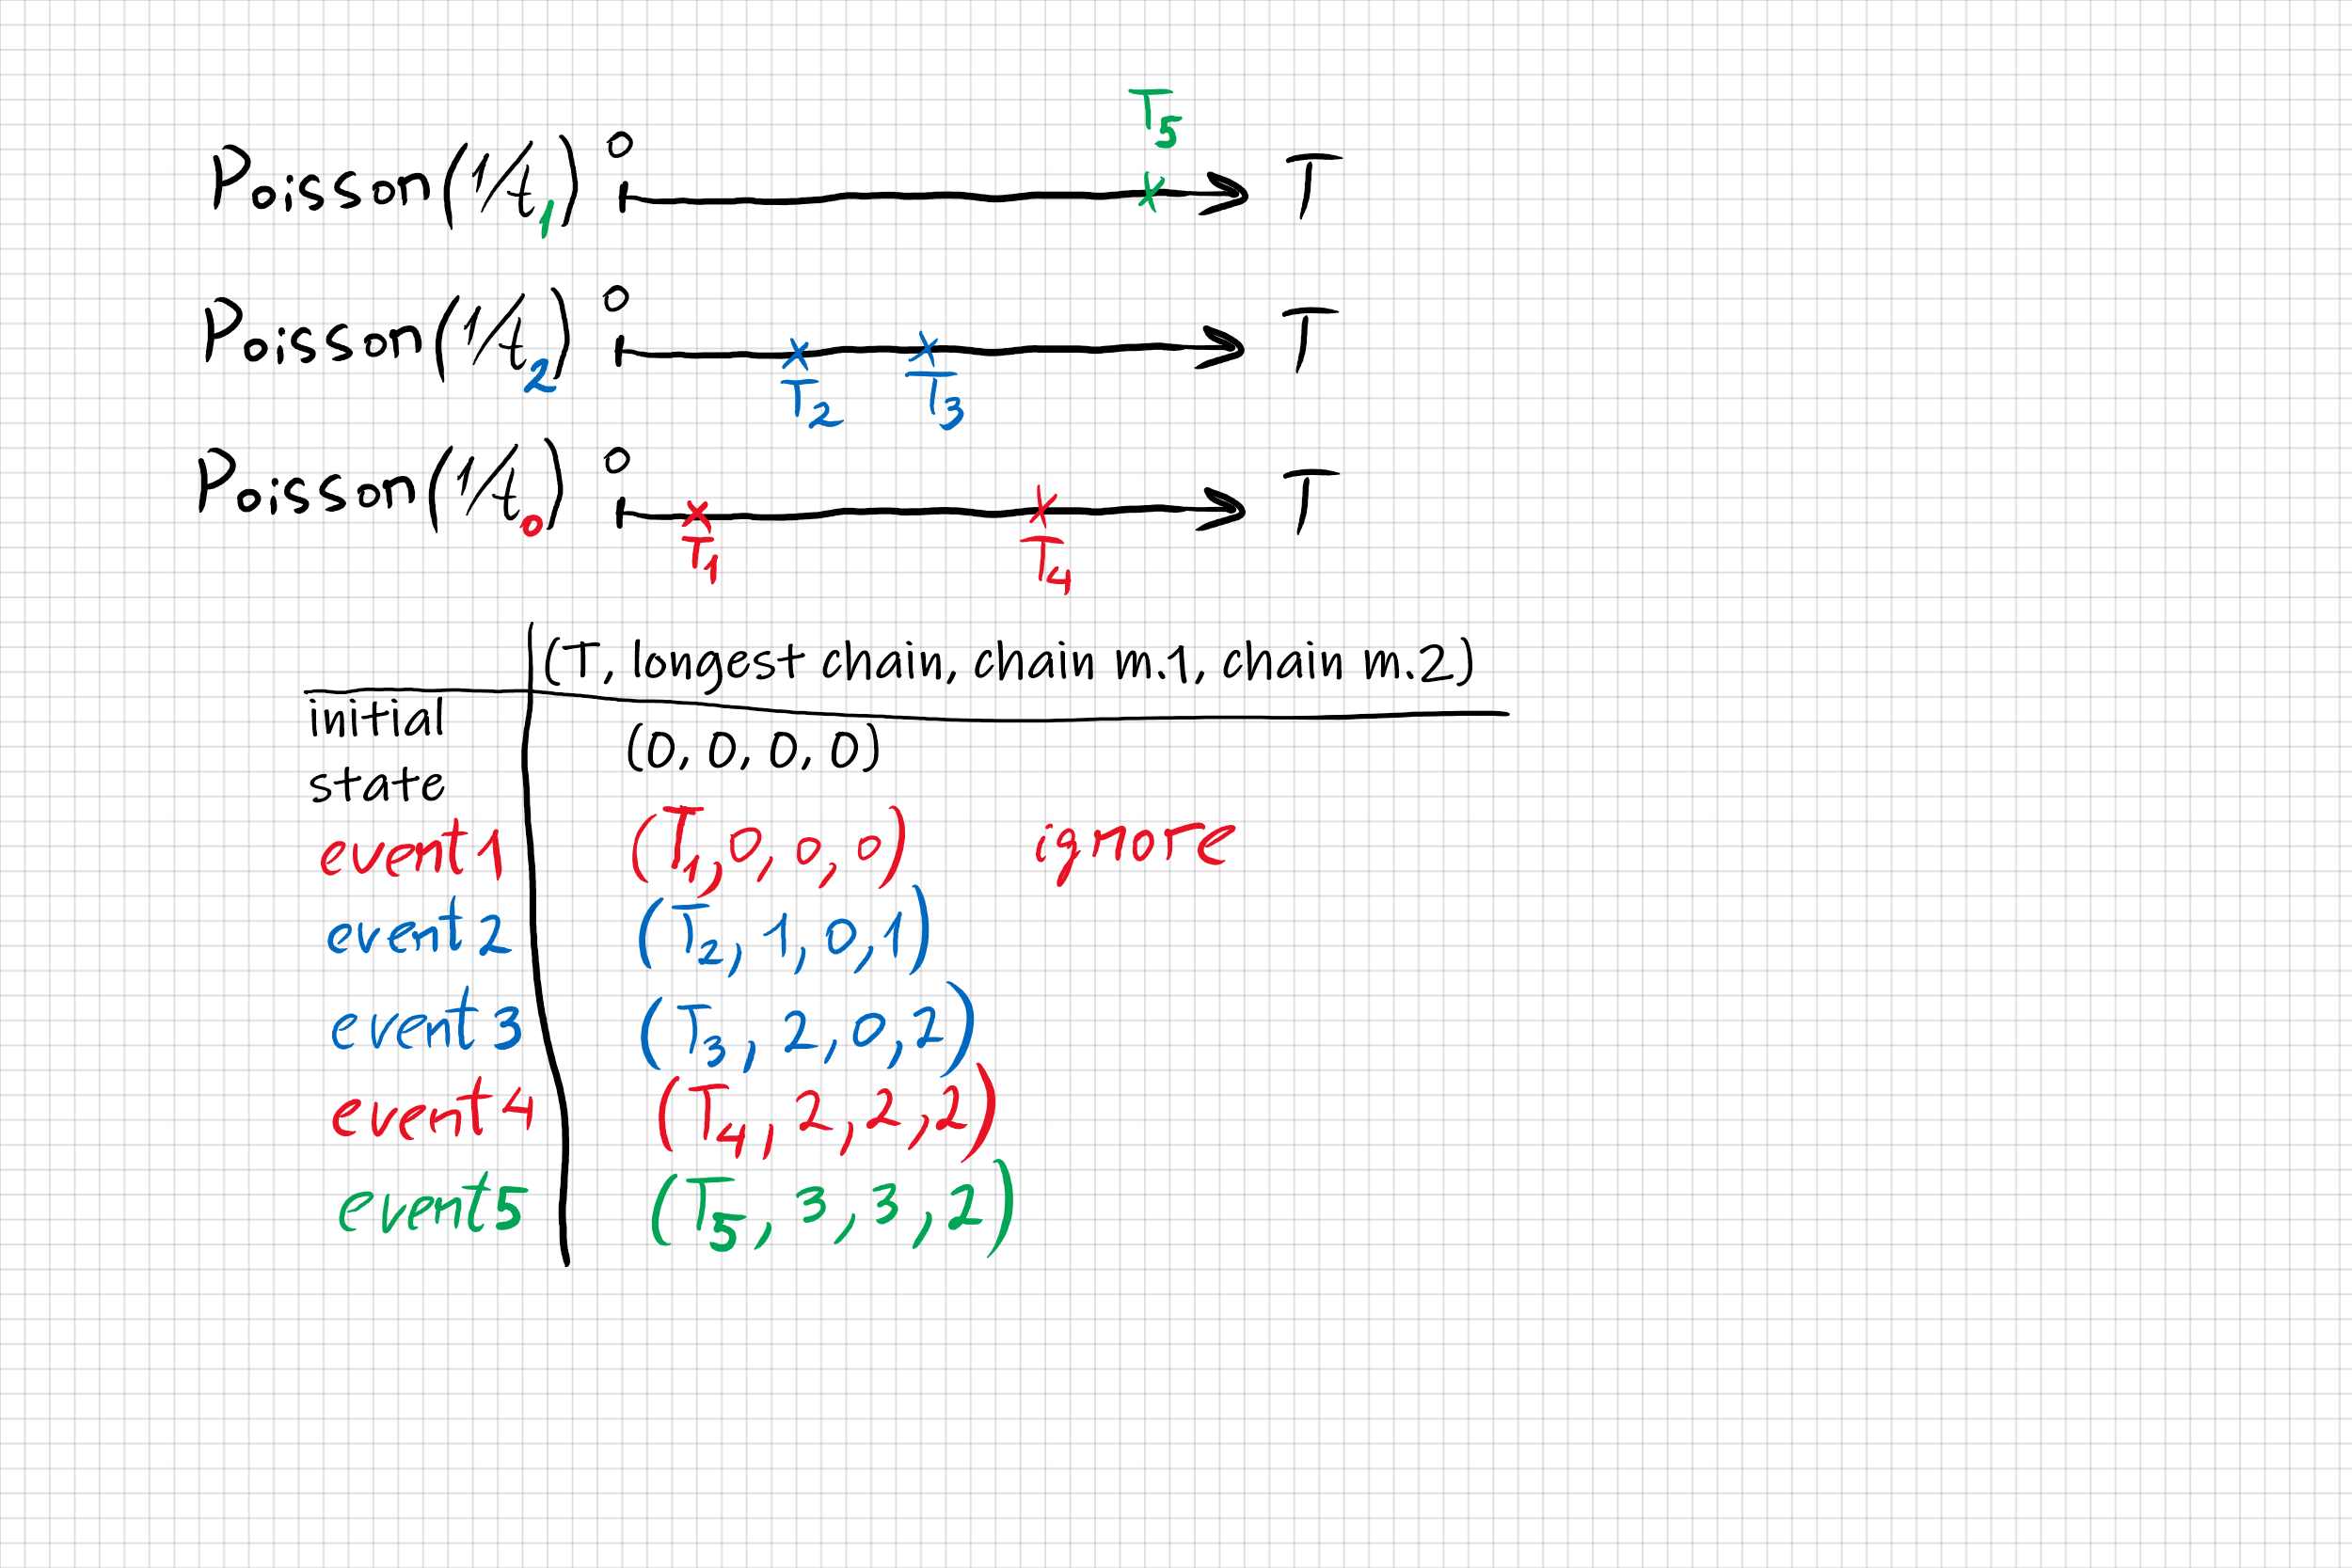

\[1\] Daley, Daryl J.; Vere-Jones, David (2003). An Introduction to the Theory of Point Processes: Volume I: Elementary Theory and Methods. Springer. ISBN 978-1475781090.

1) Implement a function to generate a sequence of tuples (time, longest chain, longest chain for miner 1, longest chain for miner 2) and run it for $t_1=t_2=1, t_0=0.5$ (1 point)

In [21]:
# code

import numpy as np
import scipy.stats

time_interval_to_simulate = 10.
t1 = 1.

# miner 1 mines at Ts
number_of_blocks_miner_1 = scipy.stats.poisson(time_interval_to_simulate * (1/t1)).rvs()
event_times_miner_1 =  sorted(scipy.stats.uniform.rvs(loc=0, 
                                                      scale=time_interval_to_simulate, 
                                                      size=number_of_blocks_miner_1))


In [22]:
def generate_event_times(t, process_id, simulate_time): # генерируем эвенты в зависимости от t
    time_interval_to_simulate = simulate_time
    number_of_blocks = scipy.stats.poisson(time_interval_to_simulate * (1/t)).rvs()
    event_times = sorted(scipy.stats.uniform.rvs(loc=0, 
                                                scale=time_interval_to_simulate, 
                                                size=number_of_blocks))  
    
    num_of_event = [(event_times[i],process_id) for i in range(len(event_times))]
    return num_of_event



def generate_main_sequence(t_list):
    event_times = []
    for i in range(len(t_list)): 
        event_times += generate_event_times(t_list[i], i, 10)
    event_times = sorted(event_times, key=lambda x: x[0]) # сортируем эвенты по времени
    
    # строим sequence
    sequence = [0,0,0,0]
    
    for event in event_times:
        sequence[0] = event[0]
        if event[1] == 0: # синхронизация
            sequence[2] = sequence[1]
            sequence[3] = sequence[1]
        elif event[1] == 1: # майнер 1
            sequence[2] += 1
            sequence[1] = max(sequence[2], sequence[3])
        else: # майнер 2
            sequence[3] += 1
            sequence[1] = max(sequence[2], sequence[3])
    
    total_blocks_count = 0
    for event in event_times:
        if(event[1] != 0): # не считаем синхронизацию
          total_blocks_count += 1
    
    return sequence, total_blocks_count
    
generate_main_sequence([0.5, 1., 1. ])

([8.824800198934241, 11, 11, 11], 15)

2) Plot the ratio of the blocks in the main chain to the number of generated blocks as a function of $t_0 \in (0, 2]$ for fixed $t_1=t_2=1$ (2 points)

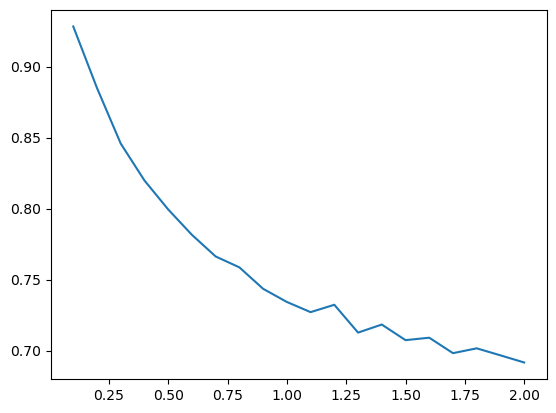

In [23]:
x = []
y = []
for i in np.arange(0.1, 2.1, 0.1):
    data = []
    for j in range (0, 300):
        main_sequence, total_blocks_count = generate_main_sequence([i, 1., 1.])
        data.append(main_sequence[1]/total_blocks_count)
    y.append(np.mean(data))
    x.append(i)

plt.plot(x, y)

3) Let there be an adversary miner 3 with a rate $t_3 = 0.9$ and instant communication with miners 1 and 2. Let him mine his own branch. Plot the empirical probability to go $6$ blocks ahead of the miners' 1 and 2 main chain during $T=100$ as a function of $t_0$ for fixed $t_1=t_2=1$ (3 points)

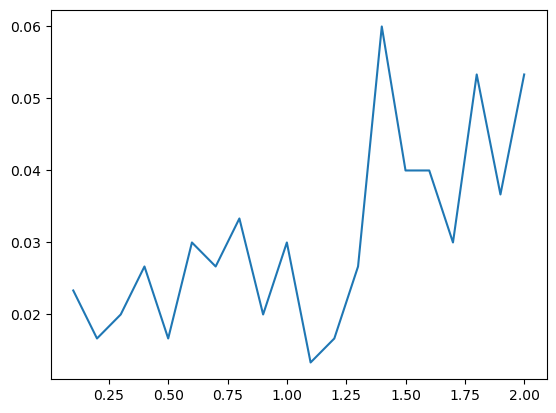

In [24]:
def generate_main_sequence_with_adversary(t_list):
    event_times = []
    for i in range(len(t_list)): 
        event_times += generate_event_times(t_list[i], i, 100)
    event_times = sorted(event_times, key=lambda x: x[0]) # сортируем эвенты по времени
    
    # строим sequence
    sequence = [0,0,0,0] 

    adversary_mainer = 0
    
    for event in event_times:
        sequence[0] = event[0]
        if event[1] == 0: # синхронизация
            sequence[2] = sequence[1]
            sequence[3] = sequence[1]
            adversary_mainer = max(adversary_mainer, sequence[1])
        elif event[1] == 1: # майнер 1
            sequence[2] += 1
            sequence[1] = max(sequence[2], sequence[3])
        elif event[1] == 2 : # майнер 2
            sequence[3] += 1
            sequence[1] = max(sequence[2], sequence[3])
        else: # противниу
            adversary_mainer+=1
            
    return sequence[1], adversary_mainer

x = []
y = []
for i in np.arange(0.1, 2.1, 0.1):
    num = 0
    for j in range (0, 300):
        main_chain, adversary_chain = generate_main_sequence_with_adversary([i, 1., 1., 0.9])
        if(adversary_chain - main_chain == 6):
            num+=1
    y.append(num/300)
    x.append(i)

plt.plot(x, y)


4*) Demonstrate 51% attack by miner 3 (2 bonus points)

In [25]:
# code